In [2]:
import os
import pickle
import numpy as np
from tqdm.notebook import tqdm

from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add

import nltk
from nltk.translate.bleu_score import sentence_bleu

In [3]:
print(os.getcwd())

C:\Users\patel\DeepCap-Final


In [4]:
BASE_DIR = r"C:\Users\patel\DeepCap-Final\archive"
WORKING_DIR = BASE_DIR
BASE_DIR

'C:\\Users\\patel\\DeepCap-Final\\archive'

# Extract Image features

In [5]:
model = VGG16()
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [5]:
features = {}
directory = os.path.join(BASE_DIR, 'Images')

for img_name in tqdm(os.listdir(directory)):
    
    img_path = directory + '/' + img_name
    image = load_img(img_path, target_size=(224, 224))
    image = img_to_array(image)
    
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    image = preprocess_input(image)
    feature = model.predict(image, verbose=0)
    image_id = img_name.split('.')[0]

    features[image_id] = feature

  0%|          | 0/8091 [00:00<?, ?it/s]

In [6]:
# storing features in pickle
pickle.dump(features, open(os.path.join(WORKING_DIR, 'features.pkl'), 'wb'))

In [6]:
# loading features from pickle
with open(os.path.join(WORKING_DIR, 'features.pkl'), 'rb') as f:
    features = pickle.load(f)

# Load the Captions Data

In [7]:
with open(os.path.join(BASE_DIR, 'captions.txt'), 'r') as f:
    next(f)
    captions_doc = f.read()


In [8]:
mapping = {}
for line in tqdm(captions_doc.split('\n')):
    
    tokens = line.split(',')
    if len(line) < 2:
        continue
    image_id, caption = tokens[0], tokens[1:]
    
    image_id = image_id.split('.')[0]

    caption = " ".join(caption)
    
    if image_id not in mapping:
        mapping[image_id] = []

    mapping[image_id].append(caption)

  0%|          | 0/40456 [00:00<?, ?it/s]

In [9]:
len(mapping)

8091

# Preprocess text Data

In [10]:
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            # take one caption at a time
            caption = captions[i]
            # preprocessing steps
            # convert to lowercase
            caption = caption.lower()
            # delete digits, special chars, etc., 
            caption = caption.replace('[^A-Za-z]', '')
            # delete additional spaces
            caption = caption.replace('\s+', ' ')
            # add start and end tags to the caption
            caption = 'startseq ' + " ".join([word for word in caption.split() if len(word)>1]) + ' endseq'
            captions[i] = caption

In [11]:
# before preprocessing of text
mapping['221973402_ecb1cd51f1']

['a black dog chases a boy wearing red and blue .',
 'A boy plays with a dog and a Frisbee .',
 'A dog with a Frisbee in its mouth chasing a boy in a field .',
 'A red shirted boy and a black dog with a Frisbee run in the green grass .',
 'The small boy is running in front of a black dog with a Frisbee in its mouth .']

In [12]:
# preprocessing the text
clean(mapping)

In [13]:
# after preprocessing of text
mapping['221973402_ecb1cd51f1']

['startseq black dog chases boy wearing red and blue endseq',
 'startseq boy plays with dog and frisbee endseq',
 'startseq dog with frisbee in its mouth chasing boy in field endseq',
 'startseq red shirted boy and black dog with frisbee run in the green grass endseq',
 'startseq the small boy is running in front of black dog with frisbee in its mouth endseq']

In [14]:
all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)


In [15]:
len(all_captions)

40455

In [16]:
all_captions[:100]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq',
 'startseq black dog and spotted dog are fighting endseq',
 'startseq black dog and tri-colored dog playing with each other on the road endseq',
 'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq',
 'startseq little girl covered in paint sits in front of painted rainbow with her hands in bowl endseq',
 'startseq little girl is sitting in front of large painted rainbow endseq',
 'startseq small girl in the grass plays with fingerpaints in front of white canvas 

In [17]:
# tokenizing the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

In [18]:
vocab_size

8485

In [19]:
# get maximum length of the caption available
max_length = max(len(caption.split()) for caption in all_captions)
max_length

35

# Training and Testing data split

In [20]:
image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.90)
train = image_ids[:split]
test = image_ids[split:]

In [21]:
# creating data generator to get data in batch (avoids session crash)
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    # loop over images
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            # process each caption
            for caption in captions:
                # encode the sequence
                seq = tokenizer.texts_to_sequences([caption])[0]
                # split the sequence into X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pairs
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]  #one hot encoding
                    
                    # store the sequences
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield [X1, X2], y
                X1, X2, y = list(), list(), list()
                n = 0

# Model Creation

In [23]:
# encoder model
# image feature layers
inputs1 = Input(shape=(4096,))
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
# sequence feature layers
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

# decoder model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

# plot the model
# plot_model(model, show_shapes=True)

In [26]:
# training the model
epochs = 30
batch_size = 32
steps = len(train) // batch_size

for i in range(epochs):
    # create data generator
    generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
    # fit for one epoch
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

227/227 [==============================] - 876s 4s/step - loss: 1.9768


In [27]:
# save the model
model.save(WORKING_DIR+'/best_model.h5')

In [24]:
from tensorflow.keras.models import load_model

# Load the model
model = load_model(WORKING_DIR + '/best_model.h5')

# Generate Captions for the Image

In [25]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None


In [26]:
# generate caption for an image
def predict_caption(model, image, tokenizer, max_length):
    # add start tag for generation process
    in_text = 'startseq'
    # iterate over the max length of sequence
    for i in range(max_length):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad the sequence
        sequence = pad_sequences([sequence], max_length)
        # predict next word
        yhat = model.predict([image, sequence], verbose=0)
        # get index with high probability
        yhat = np.argmax(yhat)
        # convert index to word
        word = idx_to_word(yhat, tokenizer)
        # stop if word not found
        if word is None:
            break
        # append word as input for generating next word
        in_text += " " + word
        # stop if we reach end tag
        if word == 'endseq':
            break
      
    return in_text

# Visualize the results

In [27]:
from PIL import Image
import matplotlib.pyplot as plt

In [28]:
def clean_caption(caption):
    # Remove 'startseq' and 'endseq' from the caption
    return caption.replace('startseq', '').replace('endseq', '').strip()

In [29]:
def generate_caption(image_name):
    # Load the image
    image_id = image_name.split('.')[0]
    img_path = os.path.join(BASE_DIR, "Images", image_name)
    image = Image.open(img_path)
    captions = mapping[image_id]

    print('---------------------Actual---------------------')
    for caption in captions:
        # Clean and print each actual caption
        print(clean_caption(caption))

    # Predict the caption
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    cleaned_pred = clean_caption(y_pred)

    print('--------------------Predicted--------------------')
    print(cleaned_pred)
    plt.imshow(image)

---------------------Actual---------------------
black dog is in the grass with woman in jeans
grey in grey sweashirt running alongside of small dog
person playing with their black dog in the grass
woman and dog are running in field
woman flies kite in field while her dog watches
--------------------Predicted--------------------
man and woman are playing with ball in the grass


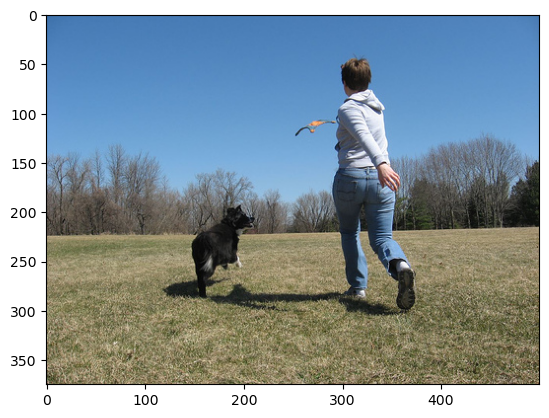

In [30]:
generate_caption("460195978_fc522a4979.jpg")

---------------------Actual---------------------
little girl covered in paint sits in front of painted rainbow with her hands in bowl
little girl is sitting in front of large painted rainbow
small girl in the grass plays with fingerpaints in front of white canvas with rainbow on it
there is girl with pigtails sitting in front of rainbow painting
young girl with pigtails painting outside in the grass
--------------------Predicted--------------------
two children in green dresses and green overalls are painting in the rainbow


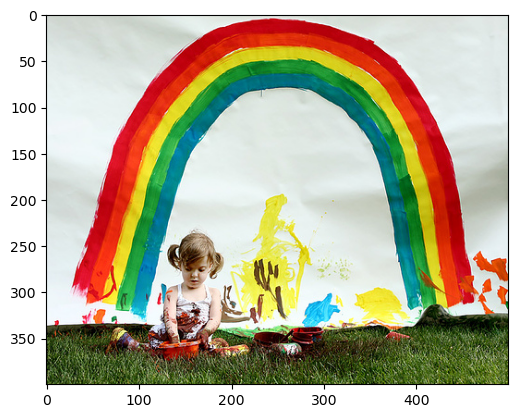

In [31]:
generate_caption("1002674143_1b742ab4b8.jpg")

---------------------Actual---------------------
man in hat is displaying pictures next to skier in blue hat
man skis past another man displaying paintings in the snow
person wearing skis looking at framed pictures set up in the snow
skier looks at framed pictures in the snow next to trees
man on skis looking at artwork for sale in the snow
--------------------Predicted--------------------
two people in the snow


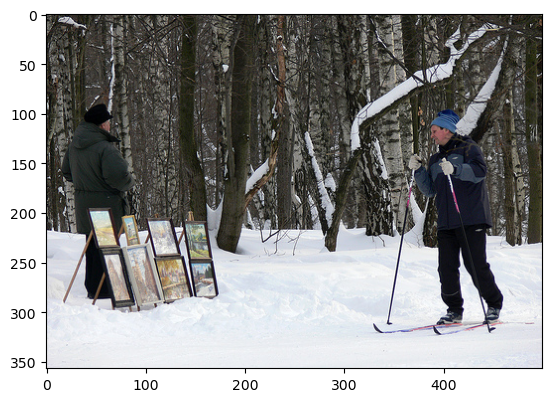

In [60]:
generate_caption("101669240_b2d3e7f17b.jpg")

---------------------Actual---------------------
person wearing jeans sits on top of horse saddle
woman in jeans is sitting on the saddle of horse
the girl is sitting on top of saddle
the person is sitting on top of horse
this person is sitting in saddle
--------------------Predicted--------------------
woman wearing glasses sits on bench


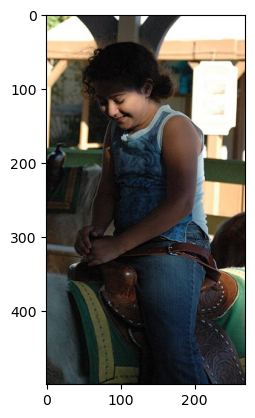

In [61]:
generate_caption("282960970_574aa1ba49.jpg")

---------------------Actual---------------------
blonde toddler in light green shirt sitting in green chair surrounded by other green chairs
cute toddler girl waits in her stroller
little blonde girl is sitting on green chair
little girl is turned around in her seat at an event
young girl with blond hair holding onto rail
--------------------Predicted--------------------
little girl in green shirt is turned over her head over green chair


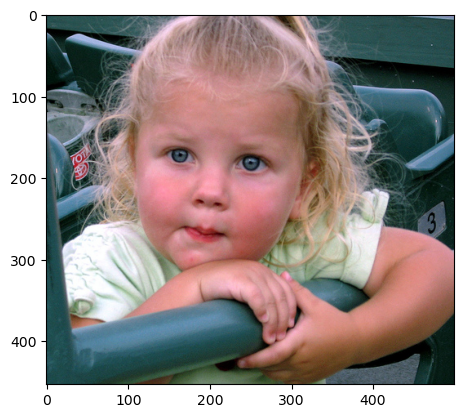

In [46]:
generate_caption("367925122_335ed279a8.jpg")

---------------------Actual---------------------
kayaker plungles into the river
person in canoe is rafting in wild waters
person is half submerged in water in their yellow kayak
woman has positioned her kayak nose down in the water
the man in yellow kayak is paddling through rough waters
--------------------Predicted--------------------
person in yellow kayak is paddling through the water


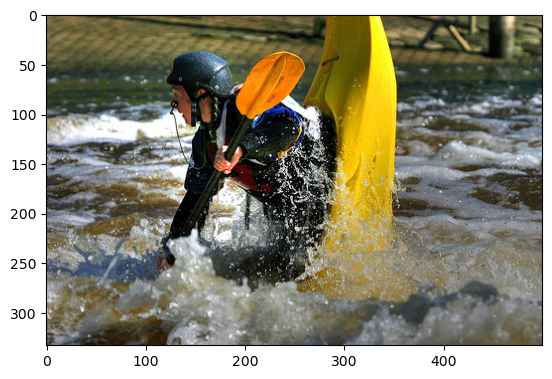

In [47]:
generate_caption("368393384_86defdcde8.jpg")

---------------------Actual---------------------
girl in purple top holds toddler between herself and another girl on the grass in front of bush
three children sit on the grass
three little children are sitting in the grass
three little girls are sitting on the grass
three young girls are sitting on the lawn
--------------------Predicted--------------------
two little girls are sitting on the grass


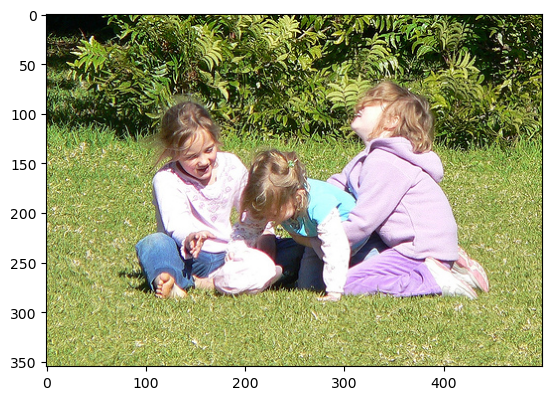

In [48]:
generate_caption("368954110_821ccf005c.jpg")

---------------------Actual---------------------
dog jumping up to touch woman 's hand
dog jumps to an elderly woman
an airborne dog on leash with woman
the small dog is leaping in the air toward the woman 's hand
the woman in the blue sweater encourages the dog to jump in the air
--------------------Predicted--------------------
two girls are standing in front of an outdoor bench


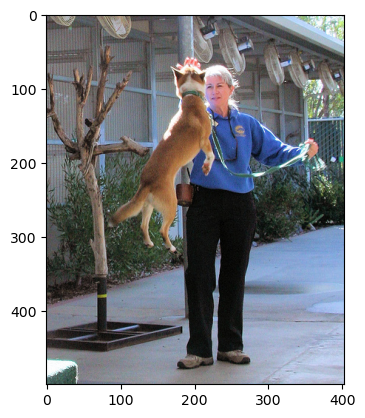

In [49]:
generate_caption("391579205_c8373b5411.jpg")

---------------------Actual---------------------
girl in pink coat plays in the leaves
girl in pink coat throws leaves in the air
little girl in pink jacket throwing some leafs up in the air
little girl in pink jacket throws leaves over her head in front of fence
young girl in pink coat throwing leaves into the air
--------------------Predicted--------------------
young girl in pink coat and white flowered flowered dress


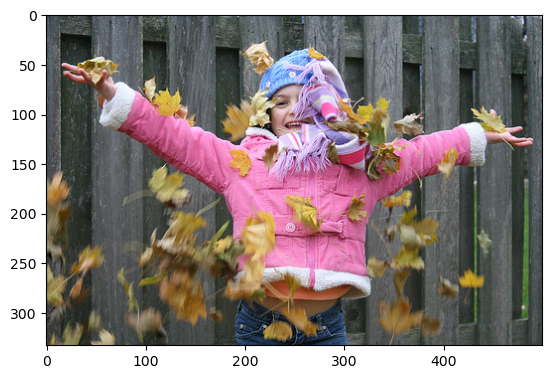

In [50]:
generate_caption("3707738261_777075e885.jpg")

In [ ]:
score = sentence_bleu(tokenizer)

print('BLEU score:',score)

In [33]:
vgg_model = VGG16()
# restructure the model
vgg_model = Model(inputs=vgg_model.inputs, outputs=vgg_model.layers[-2].output)

'startseq two horses are staring at fire endseq'

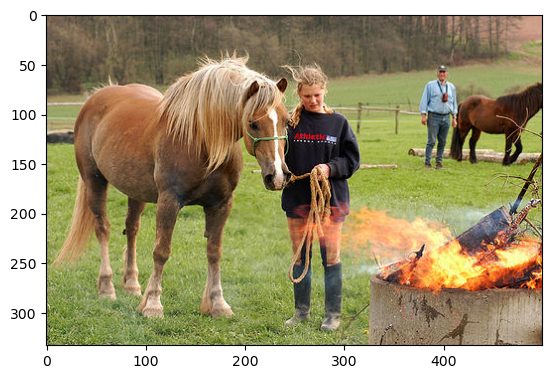

In [38]:
image_path = r"D:\Projects\DeepCap-Project\Flicker8k_Dataset\10815824_2997e03d76.jpg"

image = Image.open(image_path)
plt.imshow(image)
# load image
image = load_img(image_path, target_size=(224, 224))
# convert image pixels to numpy array
image = img_to_array(image)
# reshape data for model
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
# preprocess image for vgg
image = preprocess_input(image)
# extract features
feature = vgg_model.predict(image, verbose=0)
# predict from the trained model
predict_caption(model, feature, tokenizer, max_length)

In [39]:
# Initialize VGG16 model for feature extraction
def initialize_vgg16_model():
    base_model = VGG16()
    vgg_model = Model(inputs=base_model.inputs, outputs=base_model.layers[-2].output)
    return vgg_model

In [40]:
def generate_caption(image_path, vgg_model, caption_model, tokenizer, max_length):
    # Display the image
    image = Image.open(image_path)
    plt.imshow(image)
    plt.axis('off')
    plt.show()

    # Load, preprocess, and reshape image
    image = load_img(image_path, target_size=(224, 224))
    image = img_to_array(image)
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    image = preprocess_input(image)

    # Extract features using the VGG16 model
    feature = vgg_model.predict(image, verbose=0)

    # Generate and return the caption using the provided caption model
    caption = predict_caption(caption_model, feature, tokenizer, max_length)
    return caption

In [41]:
vgg_model = initialize_vgg16_model()

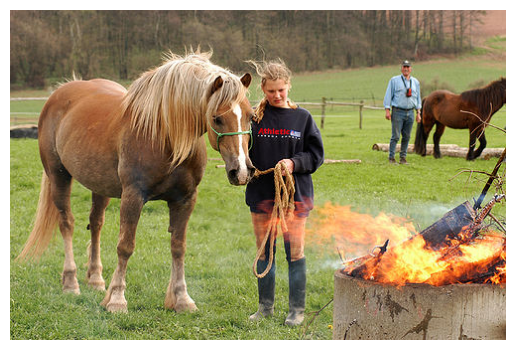

Generated Caption: two horses are staring at fire


In [43]:
image_path = r"D:\Projects\DeepCap-Project\Flicker8k_Dataset\10815824_2997e03d76.jpg"
caption = generate_caption(image_path, vgg_model, model, tokenizer, max_length)
print("Generated Caption:", clean_caption(caption))

In [46]:
!pip install requests

In [49]:
import requests
from io import BytesIO

def generate_caption_from_url(image_url, vgg_model, caption_model, tokenizer, max_length):
    # Fetch image from URL
    response = requests.get(image_url)
    image = Image.open(BytesIO(response.content))
    
    # Display the image
    plt.imshow(image)
    plt.axis('off')
    plt.show()
    
    # Preprocess image for the model
    image = image.resize((224, 224))
    image = img_to_array(image)
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    image = preprocess_input(image)
    
    # Extract features using the VGG16 model
    feature = vgg_model.predict(image, verbose=0)
    
    # Generate and return the caption using the provided caption model
    caption = predict_caption(caption_model, feature, tokenizer, max_length)
    return caption

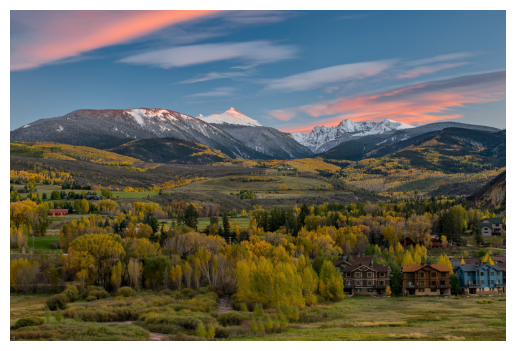

Generated Caption: two hikers are walking along mountain trail


In [52]:
image_url = "https://photographylife.com/wp-content/uploads/2014/10/Nikon-D750-Sample-Image-36.jpg"
caption = generate_caption_from_url(image_url, vgg_model, model, tokenizer, max_length)
print("Generated Caption:", clean_caption(caption))

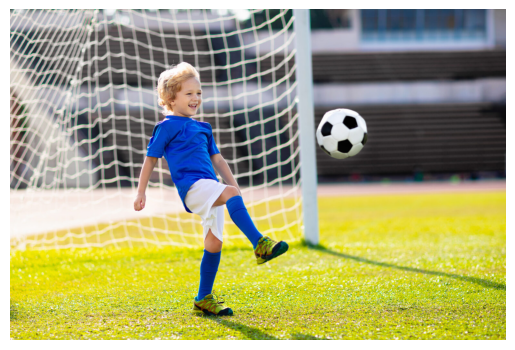

Generated Caption: boy in blue shirt swings on yellow ball


In [54]:
image_url = "https://designsandlines.co.uk/wp-content/uploads/2021/08/kid-in-football-goal-with-child-soccer-player-1536x1024.jpg"
caption = generate_caption_from_url(image_url, vgg_model, model, tokenizer, max_length)
print("Generated Caption:", clean_caption(caption))

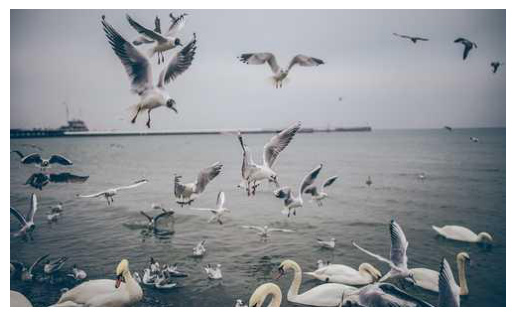

Generated Caption: flock of pelicans in park


In [72]:
image_url = "https://picsum.photos/500/300"
caption = generate_caption_from_url(image_url, vgg_model, model, tokenizer, max_length)
print("Generated Caption:", clean_caption(caption))

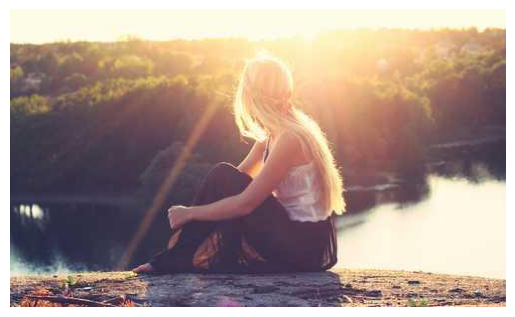

Generated Caption: woman in pink shirt is standing on fire


In [76]:
image_url = "https://picsum.photos/500/300"
caption = generate_caption_from_url(image_url, vgg_model, model, tokenizer, max_length)
print("Generated Caption:", clean_caption(caption))